# ConvLSTM On Earthquake Time Series Data

In [ ]:
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from enum import Enum
import time

In [ ]:
torch_data_type = torch.float32

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class FileData:
    def __init__(
        self,
        name,
        acc_index,
        vel_index,
        dsp_index,
        lst_index,
        dt_acc,
        dt_vel,
        dt_dsp,
        unit_acc,
        unit_vel,
        unit_dsp,
        acc_values,
        vel_values,
        dsp_values,
        dt_sampling,
        acc_values_sampled,
        vel_values_sampled,
        dsp_values_sampled,
    ):
        self.name = name
        self.acc_index = acc_index
        self.vel_index = vel_index
        self.dsp_index = dsp_index
        self.lst_index = lst_index
        self.dt_acc = dt_acc
        self.dt_vel = dt_vel
        self.dt_dsp = dt_dsp
        self.unit_acc = unit_acc
        self.unit_vel = unit_vel
        self.unit_dsp = unit_dsp
        self.acc_values = acc_values
        self.vel_values = vel_values
        self.dsp_values = dsp_values
        self.dt_sampling = dt_sampling
        self.acc_values_sampled = acc_values_sampled
        self.vel_values_sampled = vel_values_sampled
        self.dsp_values_sampled = dsp_values_sampled
        self.ID = 0
        self.u_r = None
        self.ud_r = None
        self.udd_r = None
        self.t = None  # time vector

    def __str__(self) -> str:
        return f"{self.name, self.acc_index, self.vel_index, self.dsp_index, self.lst_index, self.dt_acc, self.dt_dsp, self.unit_acc, self.unit_vel, self.unit_dsp, self.acc_values, self.vel_values, self.dsp_values, self.dt_sampling, self.acc_values_sampled, self.vel_values_sampled, self.dsp_values_sampled, self.ID, self.u_r, self.ud_r, self.udd_r, self.t}"

    def __repr__(self) -> str:
        return self.__str__()

In [ ]:
class NormalizationOption(Enum):
    NoScaling = 0
    ScaleShiftStandard = 1
    ScaleShiftAll = 2
    ScaleAll = 3
    ScaleFeatureBased = 4

class TensorsType(Enum):
    Tensorflow = 0
    Torch = 1

class Dataset:
    def __init__(self, filename: str, normalizationOption: NormalizationOption):
      self.data = np.asarray(pd.read_pickle(filename), dtype=object)
      self.normalizationOption = normalizationOption

      self.max_timesteps = max(len(file_data.acc_values_sampled) for file_data in self.data)
      self.min_timesteps = min(len(file_data.acc_values_sampled) for file_data in self.data)

      self.max_abs_acc_input  = max(np.absolute(file_data.acc_values_sampled).max() for file_data in self.data)
      self.max_abs_acc_output = max(np.absolute(file_data.udd_r).max() for file_data in self.data)
      self.max_abs_vel_output = max(np.absolute(file_data.ud_r).max() for file_data in self.data)
      self.max_abs_dsp_output = max(np.absolute(file_data.u_r).max() for file_data in self.data)

      self.max_acc_input  = max(file_data.acc_values_sampled.max() for file_data in self.data)
      self.max_acc_output = max(file_data.udd_r.max() for file_data in self.data)
      self.max_vel_output = max(file_data.ud_r.max() for file_data in self.data)
      self.max_dsp_output = max(file_data.u_r.max() for file_data in self.data)

      self.min_acc_input  = min(file_data.acc_values_sampled.min() for file_data in self.data)
      self.min_acc_output = min(file_data.udd_r.min() for file_data in self.data)
      self.min_vel_output = min(file_data.ud_r.min() for file_data in self.data)
      self.min_dsp_output = min(file_data.u_r.min() for file_data in self.data)

      self.max_abs_all = max([self.max_abs_acc_input, self.max_abs_acc_output, self.max_abs_vel_output, self.max_abs_dsp_output])
      self.max_all     = max([self.max_acc_input, self.max_acc_output, self.max_vel_output, self.max_dsp_output])
      self.min_all     = min([self.min_acc_input, self.min_acc_output, self.min_vel_output, self.min_dsp_output])

      self.start_index=0
      self.end_index=self.min_timesteps
      self.sequence_length=self.end_index - self.start_index
      self.n_earthquakes=len(self.data)

    def print_stats(self):
      print(f'dataset.max_timesteps      {self.max_timesteps     }')
      print(f'dataset.min_timesteps      {self.min_timesteps     }')
      print(f'dataset.max_abs_acc_input  {self.max_abs_acc_input }')
      print(f'dataset.max_abs_acc_output {self.max_abs_acc_output}')
      print(f'dataset.max_abs_vel_output {self.max_abs_vel_output}')
      print(f'dataset.max_abs_dsp_output {self.max_abs_dsp_output}')
      print(f'dataset.max_acc_input      {self.max_acc_input     }')
      print(f'dataset.max_acc_output     {self.max_acc_output    }')
      print(f'dataset.max_vel_output     {self.max_vel_output    }')
      print(f'dataset.max_dsp_output     {self.max_dsp_output    }')
      print(f'dataset.min_acc_input      {self.min_acc_input     }')
      print(f'dataset.min_acc_output     {self.min_acc_output    }')
      print(f'dataset.min_vel_output     {self.min_vel_output    }')
      print(f'dataset.min_dsp_output     {self.min_dsp_output    }')
      print(f'dataset.max_abs_all        {self.max_abs_all       }')
      print(f'dataset.max_all            {self.max_all           }')
      print(f'dataset.min_all            {self.min_all           }')

    def normalize_sequence(self,x,featureIndex=0):
      if self.normalizationOption == NormalizationOption.NoScaling:
        return x
      if self.normalizationOption == NormalizationOption.ScaleShiftStandard:
        min_value = np.min(x)
        max_value = np.max(x)
        return (x - min_value) / (max_value - min_value)
      if self.normalizationOption == NormalizationOption.ScaleShiftAll:
        return (x - self.min_all) / (self.max_all - self.min_all)
      if self.normalizationOption == NormalizationOption.ScaleAll:
        return (x) / (self.max_abs_all)
      if self.normalizationOption == NormalizationOption.ScaleFeatureBased:
        if featureIndex == 0:
          return (x) / max([self.max_abs_acc_input,self.max_abs_acc_output])
        if featureIndex == 2:
          return (x) / self.max_abs_vel_output
        if featureIndex == 1:
          return (x) / self.max_abs_dsp_output

    def rebase_sequence(self,x,featureIndex=0):
      if self.normalizationOption == NormalizationOption.ScaleShiftAll:
        return (x * (self.max_all - self.min_all) +  self.min_all)
      if self.normalizationOption == NormalizationOption.ScaleAll:
        return (x) * (self.max_abs_all)
      if self.normalizationOption == NormalizationOption.ScaleFeatureBased:
        if featureIndex == 0:
          return (x) * max([self.max_abs_acc_input,self.max_abs_acc_output])
        if featureIndex == 2:
          return (x) * self.max_abs_vel_output
        if featureIndex == 1:
          return (x) * self.max_abs_dsp_output

      return x


    def get_ground_acc(self):
      ground_acc = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        acc_data = data.acc_values_sampled[self.start_index:self.end_index]
        ground_acc[i] = self.normalize_sequence(acc_data,0)

      return ground_acc

    def get_response_acc(self):
      response_acc = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        acc_data = data.udd_r[self.start_index:self.end_index]
        response_acc[i] = self.normalize_sequence(acc_data,0)

      return response_acc

    def get_ground_vel(self):
      ground_vel = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        vel_data = data.vel_values_sampled[self.start_index:self.end_index]
        ground_vel[i] = self.normalize_sequence(vel_data,2)

      return ground_vel

    def get_response_vel(self):
      response_vel = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        vel_data = data.ud_r[self.start_index:self.end_index]
        response_vel[i] = self.normalize_sequence(vel_data,2)

      return response_vel

    def get_ground_dsp(self):
      ground_dsp = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        dsp_data = data.dsp_values_sampled[self.start_index:self.end_index]
        ground_dsp[i] = self.normalize_sequence(dsp_data,1)

      return ground_dsp

    def get_response_dsp(self):
      response_dsp = np.zeros((self.n_earthquakes, self.sequence_length))

      for i in range(self.n_earthquakes):
        data = self.data[i]
        dsp_data = data.u_r[self.start_index:self.end_index]
        response_dsp[i] = self.normalize_sequence(dsp_data,1)
      return response_dsp

    def split_data(self,tensorType,n_features,init_zeros):
      x = self.get_ground_acc()
      y1 = self.get_response_acc()
      y2 = self.get_response_dsp()


      if init_zeros > 0 :
        init_zeros_tensor = np.zeros((x.shape[0],init_zeros))
        x=np.concatenate((init_zeros_tensor , x), axis=1)
        y1=np.concatenate((init_zeros_tensor , y1), axis=1)
        y2=np.concatenate((init_zeros_tensor , y2), axis=1)

      x = np.expand_dims(x, axis=2)
      if n_features == 1:
        y = np.expand_dims(y1, axis=2)
      elif n_features == 2:
        y = np.dstack((y1,y2))

      x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 13)


      if tensorType == TensorsType.Tensorflow:
        x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
        x_val_tensor = tf.convert_to_tensor(x_val, dtype=tf.float32)
        y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
        y_val_tensor =tf.convert_to_tensor(y_val, dtype=tf.float32)
      elif tensorType == TensorsType.Torch:
        x_train_tensor = torch.from_numpy(x_train).to(torch_data_type)
        x_val_tensor = torch.from_numpy(x_val).to(torch_data_type)
        y_train_tensor = torch.from_numpy(y_train).to(torch_data_type)
        y_val_tensor = torch.from_numpy(y_val).to(torch_data_type)

      return x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor

In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset

class TrainingDataset(TorchDataset):
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

In [ ]:
def plot_data(sequence1, sequence2, title, xlabel, ylabel, label1="Real", label2="Predicted"):
  x = np.arange(start=0, stop=len(sequence1), step=1) * 0.005 # time step is 0.005

  plt.plot(x, sequence1, label=label1)
  plt.plot(x, sequence2, "--", label=label2)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.legend()
  plt.show()

In [ ]:
dataset = Dataset("/content/drive/MyDrive/DL_Training_Data/all_eq_processed_data_ID_m_SDOF_linear_v003.pickle",NormalizationOption.ScaleFeatureBased)
dataset.print_stats()

dataset.max_timesteps      26799
dataset.min_timesteps      11201
dataset.max_abs_acc_input  0.9249152239983484
dataset.max_abs_acc_output 3.2218021366507346
dataset.max_abs_vel_output 0.2046758270233766
dataset.max_abs_dsp_output 0.014122405412496458
dataset.max_acc_input      0.9249152239983484
dataset.max_acc_output     3.2218021366507346
dataset.max_vel_output     0.2046758270233766
dataset.max_dsp_output     0.013713759752471104
dataset.min_acc_input      -0.772271468355947
dataset.min_acc_output     -3.0468937400870733
dataset.min_vel_output     -0.2005713543588934
dataset.min_dsp_output     -0.014122405412496458
dataset.max_abs_all        3.2218021366507346
dataset.max_all            3.2218021366507346
dataset.min_all            -3.0468937400870733


Features of interest:

1 => Acceleration only

2 => Acceleration and Displacement

Zeros are inserted at the begining of each sequence to stabilize the model response and avoid overshooting at the begining of response

In [ ]:
n_features_of_interest = 2
n_zeros_at_the_beginning = 2
batch_size = 4
x_train, x_test, y_train, y_test = dataset.split_data(TensorsType.Torch,n_features_of_interest,n_zeros_at_the_beginning)
train_dataloader=torch.utils.data.DataLoader(TrainingDataset(x_train,y_train), batch_size=batch_size, shuffle=False,  num_workers=1)
test_dataloader =torch.utils.data.DataLoader(TrainingDataset(x_test,y_test)  , batch_size=batch_size, shuffle=False,  num_workers=1)

torch.Size([4, 11203, 1])
torch.Size([4, 11203, 2])


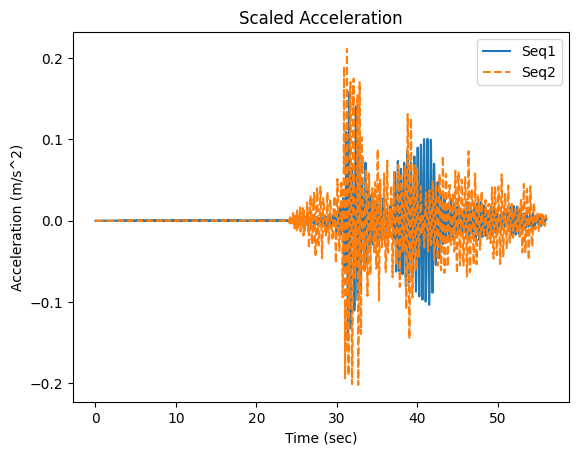

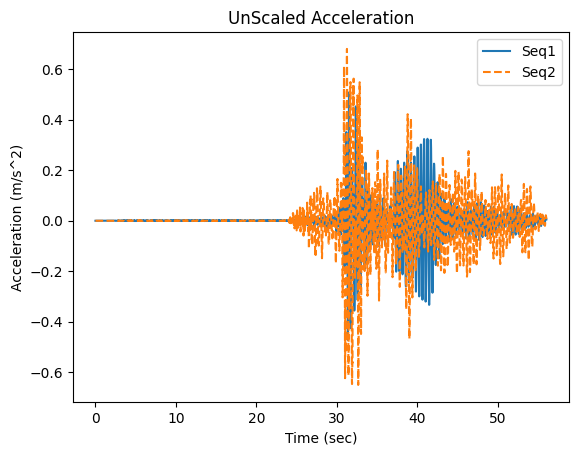

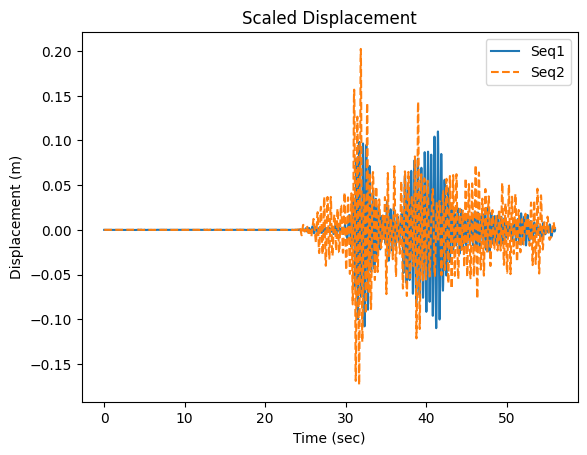

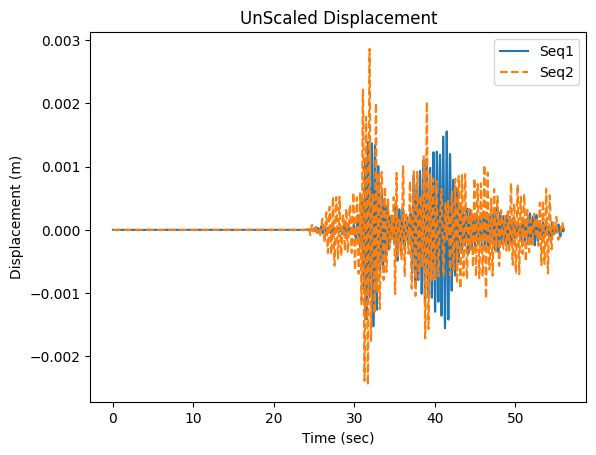

In [ ]:
train_input, train_output_target = next(iter(train_dataloader))
print(train_input.shape)
print(train_output_target.shape)
plot_data(train_output_target[0,:,0].numpy(), train_output_target[1,:,0].numpy(), "Scaled Acceleration", "Time (sec)", "Acceleration (m/s^2)" , "Seq1" , "Seq2")
plot_data(dataset.rebase_sequence(train_output_target[0,:,0].numpy(),0), dataset.rebase_sequence(train_output_target[1,:,0].numpy(),0), "UnScaled Acceleration", "Time (sec)", "Acceleration (m/s^2)" , "Seq1" , "Seq2")
plot_data(train_output_target[0,:,1].numpy(), train_output_target[1,:,1].numpy(), "Scaled Displacement", "Time (sec)", "Displacement (m)" , "Seq1" , "Seq2")
plot_data(dataset.rebase_sequence(train_output_target[0,:,1].numpy(),1), dataset.rebase_sequence(train_output_target[1,:,1].numpy(),1), "UnScaled Displacement", "Time (sec)", "Displacement (m)" , "Seq1" , "Seq2")

# Defining Model

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [ ]:
best_model_path="/content/drive/MyDrive/DL_Training_Data/model_ConvLSTM_Best_C000.pt"
last_model_path="/content/drive/MyDrive/DL_Training_Data/model_ConvLSTM_Last_C000.pt"

In [ ]:
class ConvLSTMCell1D(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size, bias):
        """
        Initialize ConvLSTM cell for 1D input.

        Parameters:
        input_size (int): Number of channels of input tensor.
        hidden_size (int): Number of channels of hidden state.
        kernel_size (int): Size of the convolutional kernel.
        bias (bool): Whether or not to add the bias.
        """
        super(ConvLSTMCell1D, self).__init__()
        self.device = None
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias

        self.conv = nn.Conv1d(in_channels=self.input_size + self.hidden_size,
                              out_channels=4 * self.hidden_size,  # for 4 gates in LSTM
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel dimension

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_size, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, seq_length):
        return (torch.zeros(batch_size, self.hidden_size, seq_length, device=self.device),
                torch.zeros(batch_size, self.hidden_size, seq_length, device=self.device))

class ConvLSTM1D(nn.Module):
    def __init__(self, input_size, hidden_size, kernel_size, bias, output_dim):
        """
        Parameters:
        input_size (int): Number of channels in the input sequence.
        hidden_size (int): Number of features in the hidden state.
        kernel_size (int): Size of the convolutional kernel.
        bias (bool): Whether or not to add the bias.
        output_dim (int): Number of channels in the output sequence.
        """
        super(ConvLSTM1D, self).__init__()

        self.conv_lstm_cell = ConvLSTMCell1D(input_size, hidden_size, kernel_size, bias)
        self.conv = nn.Conv1d(hidden_size, output_dim, kernel_size=1)

    def forward(self, x, hidden_state):
        h, c = self.conv_lstm_cell(x, hidden_state)
        out = self.conv(h)
        return out, (h, c)

floors_number = 1
response_per_floor = n_features_of_interest # acceleration and displacement
input_size = 1 # acceleration
hidden_lstm_size = 64 # Hidden layer size
kernel_size = 3
bias = True
out_features = floors_number * response_per_floor
learning_rate = 0.01 # 0.001 default
seq_length = x_train.shape[1]
# Initialize the model, loss function, and optimizer
model = ConvLSTM1D(input_size, hidden_lstm_size, kernel_size, bias, out_features).to(DEVICE)
model.conv_lstm_cell.device=DEVICE
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999))
loss_values = []

In [ ]:
def train_for_num_epochs(num_epochs):
  st = time.time() # total training start time
  for epoch in range(num_epochs):
      st_e = time.time() # epoch training start time
      epoch_loss = 0
      for inputs, target_outputs in train_dataloader:
          hidden_state = model.conv_lstm_cell.init_hidden(batch_size, seq_length)
          hidden_state = (hidden_state[0].to(DEVICE), hidden_state[1].to(DEVICE))

          # Forward pass
          inputs = torch.permute(inputs, (0, 2, 1))
          outputs, hidden_state = model(inputs.to(DEVICE), hidden_state)
          outputs = torch.permute(outputs, (0, 2, 1))

          # Detach hidden states
          hidden_state = (hidden_state[0].detach(), hidden_state[1].detach())

          # Loss
          loss = criterion(outputs, target_outputs.to(DEVICE))
          epoch_loss += loss.item()

          # Backward and optimize
          model.zero_grad()
          loss.backward()
          optimizer.step()

      loss_value = epoch_loss/len(train_dataloader)
      loss_values.append(loss_value)
      et_e = time.time() # epoch training end time
      if loss_value <= min(loss_values):
        torch.save(model.state_dict(), best_model_path)
        print(f'Epoch [{epoch+1:4.0f}/{num_epochs:4.0f}], Loss: {loss_value:.8f} , execution time: {(et_e - st_e)/60:.4f} minutes || New Best ....')
      elif (epoch+1)%50 == 0:
        print(f'Epoch [{epoch+1:4.0f}/{num_epochs:4.0f}], Loss: {loss_value:.8f} , execution time: {(et_e - st_e)/60:.4f} minutes')
  et = time.time() # total training end time
  print(f'Total training execution time: {(et - st)/60:.2f} minutes')
  torch.save(model.state_dict(), last_model_path)

In [ ]:
train_for_num_epochs(4000)

Epoch [   1/4000], Loss: 0.00440426 , execution time: 0.0058 minutes || New Best ....
Epoch [   2/4000], Loss: 0.00280999 , execution time: 0.0042 minutes || New Best ....
Epoch [   3/4000], Loss: 0.00279305 , execution time: 0.0037 minutes || New Best ....
Epoch [   4/4000], Loss: 0.00278317 , execution time: 0.0031 minutes || New Best ....
Epoch [   5/4000], Loss: 0.00277597 , execution time: 0.0041 minutes || New Best ....
Epoch [   6/4000], Loss: 0.00277104 , execution time: 0.0049 minutes || New Best ....
Epoch [   7/4000], Loss: 0.00276805 , execution time: 0.0039 minutes || New Best ....
Epoch [   8/4000], Loss: 0.00276651 , execution time: 0.0038 minutes || New Best ....
Epoch [   9/4000], Loss: 0.00276582 , execution time: 0.0032 minutes || New Best ....
Epoch [  10/4000], Loss: 0.00276550 , execution time: 0.0038 minutes || New Best ....
Epoch [  11/4000], Loss: 0.00276536 , execution time: 0.0049 minutes || New Best ....
Epoch [  22/4000], Loss: 0.00276526 , execution time: 

Min Loss 0.002685


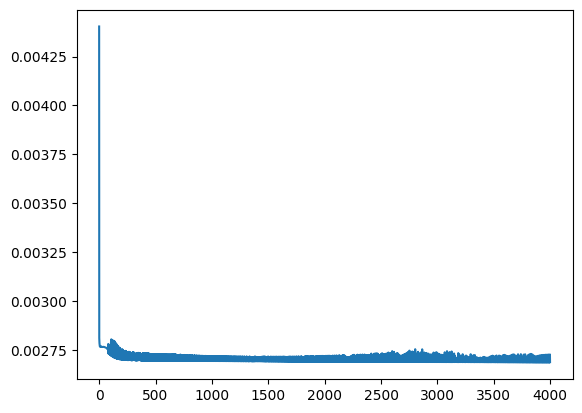

In [ ]:
print(f'Min Loss {min(loss_values):.6f}')
plt.plot(loss_values)
plt.show()

# Load Best Model

In [ ]:
best_model = ConvLSTM1D(input_size, hidden_lstm_size, kernel_size, bias, out_features).to(DEVICE)
best_model.conv_lstm_cell.device=DEVICE
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()
best_model_hidden_state_tr = best_model.conv_lstm_cell.init_hidden(32, seq_length)
best_model_hidden_state_ts = best_model.conv_lstm_cell.init_hidden(8, seq_length)

# Load Last Model

In [ ]:
last_model = ConvLSTM1D(input_size, hidden_lstm_size, kernel_size, bias, out_features).to(DEVICE)
last_model.conv_lstm_cell.device=DEVICE
last_model.load_state_dict(torch.load(last_model_path))
last_model.eval()
last_model_hidden_state_tr = last_model.conv_lstm_cell.init_hidden(32, seq_length)
last_model_hidden_state_ts = last_model.conv_lstm_cell.init_hidden(8, seq_length)

# Inspecting Performance

In [ ]:
from scipy.stats import pearsonr
def plot_for_index(selected_model,selected_model_hidden_state,index,x_data,y_data,feature):
  seq_1 = y_data[index,:,feature].numpy()
  inputs = torch.permute(x_data.to(DEVICE), (0, 2, 1))
  outputs, _ = model(inputs, selected_model_hidden_state)
  outputs = torch.permute(outputs, (0, 2, 1))
  seq_2 = outputs[index,:,feature].detach().cpu().numpy()

  seq_1 = dataset.rebase_sequence(seq_1,feature)
  seq_2 = dataset.rebase_sequence(seq_2,feature)

  plot_data(seq_1,seq_2 ,"Displacement" if (feature > 0) else "Acceleration", "Time (sec)", "Displacement (m)" if (feature > 0) else "Acceleration (m/s^2)" , "Real" , "Predicted")

def correlation_for_index(selected_model,selected_model_hidden_state,index,x_data,y_data,feature):
  seq_1 = y_data[index,:,feature].numpy()
  inputs = torch.permute(x_data.to(DEVICE), (0, 2, 1))
  outputs, _ = model(inputs, selected_model_hidden_state)
  outputs = torch.permute(outputs, (0, 2, 1))
  seq_2 = outputs[index,:,feature].detach().cpu().numpy()
  corr,_ = pearsonr(seq_2, seq_1)
  return corr

def correlation_for_all(selected_model,selected_model_hidden_state,x_data,y_data,feature):
  corr_coeffs = np.zeros(x_data.shape[0])
  for i in range(x_data.shape[0]):
    corr_coeffs[i] = correlation_for_index(selected_model,selected_model_hidden_state,i,x_data,y_data,feature)
  return corr_coeffs

def print_correlation_for_all(selected_model,selected_model_hidden_state,x_data,y_data,feature):
  corr_coeffs = correlation_for_all(selected_model,selected_model_hidden_state,x_data,y_data,feature)
  for i in range(corr_coeffs.shape[0]):
    print(f'# {i:2.0f} | {corr_coeffs[i]:5.2f}')
  print(f'-----------------------------')
  print(f'max correlation  = {corr_coeffs.max():5.2f}')
  print(f'mean correlation = {np.mean(corr_coeffs):5.2f}')

Correlation for training data (Acceleration)

In [ ]:
print_correlation_for_all(best_model,best_model_hidden_state_tr,x_train,y_train,0) #Best Stored Model

#  0 |  0.11
#  1 |  0.07
#  2 |  0.32
#  3 |  0.14
#  4 |  0.24
#  5 |  0.27
#  6 |  0.21
#  7 |  0.05
#  8 |  0.13
#  9 |  0.05
# 10 |  0.04
# 11 |  0.28
# 12 |  0.08
# 13 |  0.07
# 14 |  0.42
# 15 |  0.50
# 16 |  0.21
# 17 |  0.05
# 18 |  0.12
# 19 |  0.28
# 20 |  0.18
# 21 |  0.09
# 22 |  0.19
# 23 |  0.14
# 24 |  0.49
# 25 |  0.08
# 26 |  0.05
# 27 |  0.06
# 28 |  0.08
# 29 |  0.20
# 30 |  0.21
# 31 |  0.16
-----------------------------
max correlation  =  0.50
mean correlation =  0.17


In [ ]:
print_correlation_for_all(last_model,last_model_hidden_state_tr,x_train,y_train,0) #Last Model

#  0 |  0.11
#  1 |  0.07
#  2 |  0.32
#  3 |  0.14
#  4 |  0.24
#  5 |  0.27
#  6 |  0.21
#  7 |  0.05
#  8 |  0.13
#  9 |  0.05
# 10 |  0.04
# 11 |  0.28
# 12 |  0.08
# 13 |  0.07
# 14 |  0.42
# 15 |  0.50
# 16 |  0.21
# 17 |  0.05
# 18 |  0.12
# 19 |  0.28
# 20 |  0.18
# 21 |  0.09
# 22 |  0.19
# 23 |  0.14
# 24 |  0.49
# 25 |  0.08
# 26 |  0.05
# 27 |  0.06
# 28 |  0.08
# 29 |  0.20
# 30 |  0.21
# 31 |  0.16
-----------------------------
max correlation  =  0.50
mean correlation =  0.17


Correlation for training data (Displacement)

In [ ]:
print_correlation_for_all(best_model,best_model_hidden_state_tr,x_train,y_train,1) #Best Stored Model

#  0 |  0.04
#  1 |  0.03
#  2 |  0.34
#  3 | -0.01
#  4 |  0.20
#  5 |  0.20
#  6 |  0.38
#  7 |  0.11
#  8 |  0.45
#  9 |  0.01
# 10 | -0.04
# 11 |  0.03
# 12 |  0.04
# 13 |  0.07
# 14 |  0.19
# 15 |  0.17
# 16 |  0.29
# 17 |  0.01
# 18 |  0.03
# 19 |  0.25
# 20 |  0.16
# 21 |  0.17
# 22 |  0.25
# 23 |  0.07
# 24 |  0.17
# 25 |  0.04
# 26 | -0.00
# 27 | -0.04
# 28 |  0.03
# 29 |  0.17
# 30 |  0.22
# 31 |  0.33
-----------------------------
max correlation  =  0.45
mean correlation =  0.14


In [ ]:
print_correlation_for_all(last_model,last_model_hidden_state_tr,x_train,y_train,1) #Last Model

#  0 |  0.04
#  1 |  0.03
#  2 |  0.34
#  3 | -0.01
#  4 |  0.20
#  5 |  0.20
#  6 |  0.38
#  7 |  0.11
#  8 |  0.45
#  9 |  0.01
# 10 | -0.04
# 11 |  0.03
# 12 |  0.04
# 13 |  0.07
# 14 |  0.19
# 15 |  0.17
# 16 |  0.29
# 17 |  0.01
# 18 |  0.03
# 19 |  0.25
# 20 |  0.16
# 21 |  0.17
# 22 |  0.25
# 23 |  0.07
# 24 |  0.17
# 25 |  0.04
# 26 | -0.00
# 27 | -0.04
# 28 |  0.03
# 29 |  0.17
# 30 |  0.22
# 31 |  0.33
-----------------------------
max correlation  =  0.45
mean correlation =  0.14


Correlation for testing data (Acceleration)

In [ ]:
print_correlation_for_all(best_model,best_model_hidden_state_ts,x_test,y_test,0)#Best Stored Model

#  0 |  0.06
#  1 |  0.06
#  2 |  0.11
#  3 |  0.15
#  4 |  0.05
#  5 |  0.12
#  6 |  0.09
#  7 |  0.09
-----------------------------
max correlation  =  0.15
mean correlation =  0.09


In [ ]:
print_correlation_for_all(last_model,last_model_hidden_state_ts,x_test,y_test,0)#Last Model

#  0 |  0.06
#  1 |  0.06
#  2 |  0.11
#  3 |  0.15
#  4 |  0.05
#  5 |  0.12
#  6 |  0.09
#  7 |  0.09
-----------------------------
max correlation  =  0.15
mean correlation =  0.09


Correlation for testing data (Displacement)

In [ ]:
print_correlation_for_all(best_model,best_model_hidden_state_ts,x_test,y_test,1)#Best Stored Model

#  0 |  0.06
#  1 |  0.00
#  2 |  0.01
#  3 |  0.28
#  4 |  0.04
#  5 |  0.04
#  6 |  0.06
#  7 |  0.07
-----------------------------
max correlation  =  0.28
mean correlation =  0.07


In [ ]:
print_correlation_for_all(last_model,last_model_hidden_state_ts,x_test,y_test,1)#Last Model

#  0 |  0.06
#  1 |  0.00
#  2 |  0.01
#  3 |  0.28
#  4 |  0.04
#  5 |  0.04
#  6 |  0.06
#  7 |  0.07
-----------------------------
max correlation  =  0.28
mean correlation =  0.07


# Training Samples

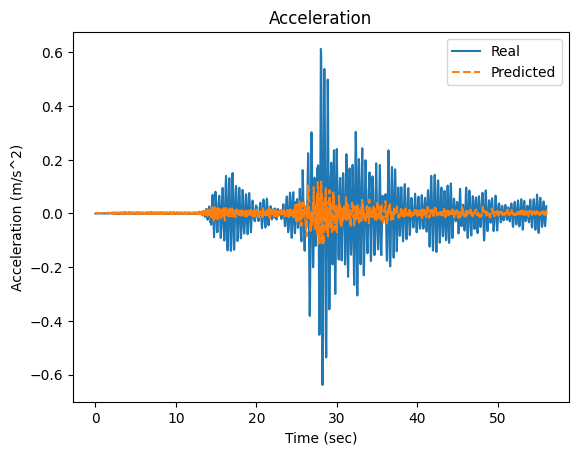

In [ ]:
plot_for_index(best_model,best_model_hidden_state_tr,8,x_train,y_train,0)

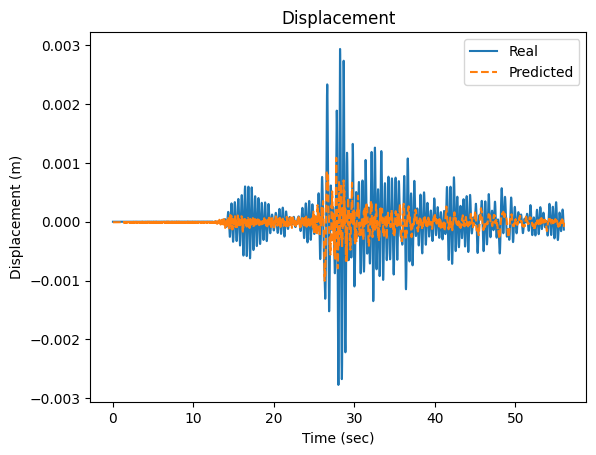

In [ ]:
plot_for_index(best_model,best_model_hidden_state_tr,8,x_train,y_train,1)

# Testing Sample

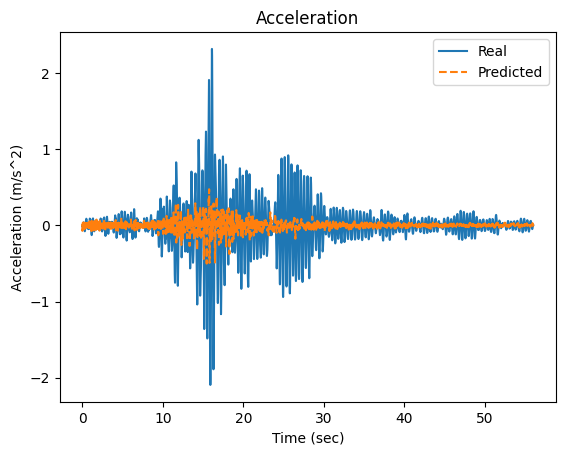

In [ ]:
plot_for_index(best_model,best_model_hidden_state_ts,3,x_test,y_test,0)

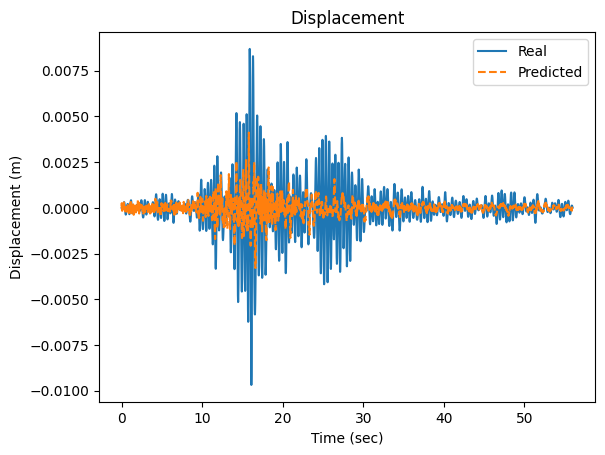

In [ ]:
plot_for_index(best_model,best_model_hidden_state_ts,3,x_test,y_test,1)

# End of testing